# Visualisation of MMR's performance 

#### Imports


In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np

#### Seaborn visual settings

In [2]:
sns.set_style(style="white")
plt.rcParams["xtick.major.size"] = 10
plt.rcParams["xtick.major.width"] = 1
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True

#### Loading data

In [3]:
data = pd.read_csv("fullOutput.csv")
display(data)

,seed,percent of training data,normal shots,domain shift,classification AUROC,pixel level AUROC,per-region-overlap (PRO) AUROC
0,1959,1,3,same,55.60,88.210424,86.300
1,1959,1,3,background,58.10,90.563182,88.100
2,1959,1,3,illumination,67.70,82.421589,81.300
3,1959,1,3,view,49.60,84.437785,83.900
4,1959,1,3,mean,57.75,86.408245,84.900
...,...,...,...,...,...,...,...
295,15356,100,521,same,85.80,93.168047,89.600
296,15356,100,521,background,84.40,88.304706,90.500
297,15356,100,521,illumination,88.50,92.532752,90.300
298,15356,100,521,view,79.10,88.586164,86.300


As my colleague performed the WinCLIP+ training separately, I received only plain-text values: 

In [4]:
# Data are the mean AUROC for 1-shot WINCLIP+
winclipData = {"domain shift = same": 80.7,
"domain shift = background": 83.1,
"domain shift = illumination": 67.4,
"domain shift = view": 82.1,
"domain shift = mean": 78.3}
winclipDataCleaner = {key.split()[-1]: value for key, value in winclipData.items()}

#### Accessing information
The model was trained with the following amounts of data: 

In [5]:
print(", ".join(map(str, data["normal shots"].unique())))

3, 13, 25, 51, 77, 129, 180, 233, 285, 363, 441, 521


With our randomly selected seeds, the MMR performance trained on the full dataset is following: 

In [6]:
data[data["percent of training data"] == 100].groupby(["domain shift"]).agg(
                      {"classification AUROC":["mean","std"]})

classification AUROC          
                             mean       std
domain shift                               
background                  84.38  0.694262
illumination                88.72  0.593296
mean                        84.59  0.331945
same                        85.74  0.296648
view                        79.52  0.501996

#### Plotting the performance of MMR at different amounts of training data

Log scale for x-axis was chosen for better clarity.

Plots for the poster:

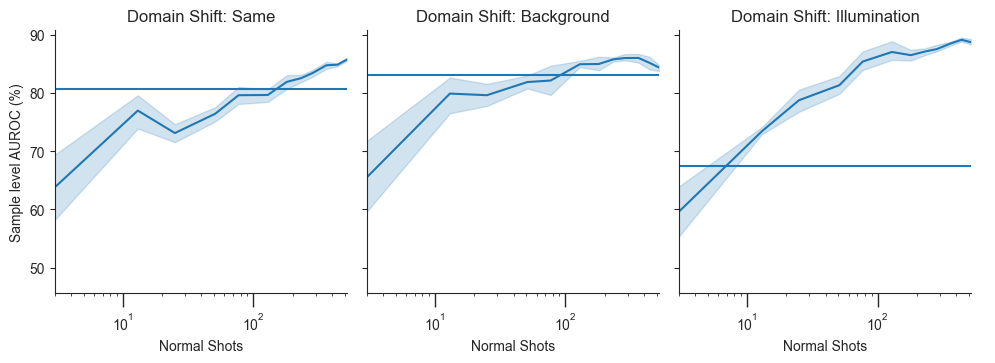

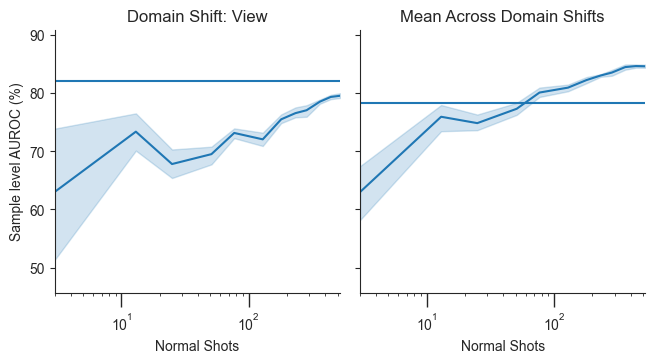

In [7]:
for ds1, ds2, ds3 in ("same", "background", "illumination"), ("view", "mean", "mean"):
    g = sns.FacetGrid(data[(data["domain shift"] == ds1) | (data["domain shift"] == ds2)| (data["domain shift"] == ds3)], col="domain shift", height=3.7/3*2/3*5/9*8, aspect=0.9)
    g.map(sns.lineplot, "normal shots", "classification AUROC")
    g.add_legend()
    plt.xscale("log")
    
    for ax in g.axes.ravel():
        ax.set_ylabel("Sample level AUROC (%)")
        ax.set_xlabel("Normal Shots")
        plt.xlim(data["normal shots"].min(), data["normal shots"].max())
        plt.ylim(data["classification AUROC"].min(), data["classification AUROC"].max())
        ax.hlines(winclipDataCleaner[ax.get_title().split()[-1]], data["normal shots"].min(), data["normal shots"].max())
        ax.set_title(f"Domain Shift: {ax.get_title().split()[-1].capitalize()}" if ax.get_title().split()[-1] != "mean" else "Mean Across Domain Shifts")
    plt.savefig(f"{ds1}, {ds2}, {ds3}.png")

An image cropping function to remove white borders:

In [8]:
def cropImage(filename):
    image = cv.imread(filename)
    rows = (image.sum(axis=2) == 255*3).all(axis=1)
    cols = (image.sum(axis=2) == 255*3).all(axis=0)
    minRow = np.where(rows != True)[0].min()
    maxRow = np.where(rows != True)[0].max()
    minCol = np.where(cols != True)[0].min()
    maxCol = np.where(cols != True)[0].max()
    cv.imwrite(filename, image[minRow:(maxRow+1), minCol:(maxCol+1)])

Plots for the report:

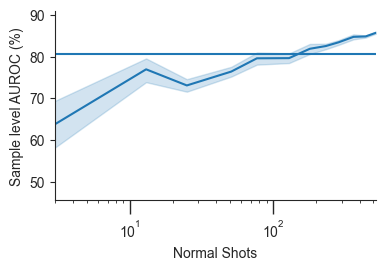

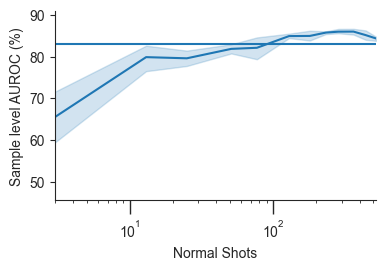

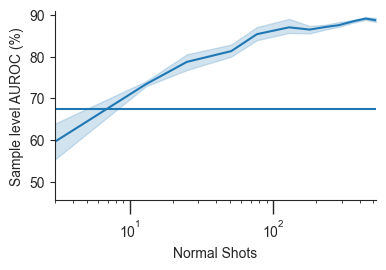

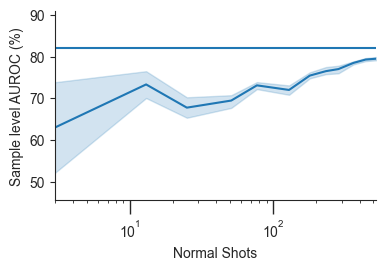

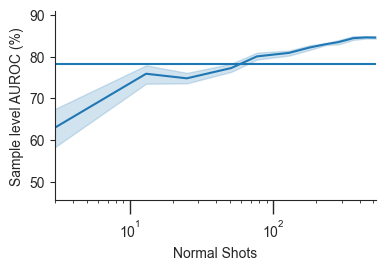

In [9]:
for ds in data["domain shift"].unique():
    fig, ax = plt.subplots(figsize=(2.2*1.8, 2.8))
    sns.lineplot(ax =ax, x="normal shots", y="classification AUROC",
                 data=data[(data["domain shift"] == ds)])
    plt.xscale("log")
    # plt.title(f"Domain Shift: {ds.capitalize()}" if ds != "mean" else "Mean Across Domain Shifts")  # This has been commented out for figure creation for the report
    ax.set_ylabel("Sample level AUROC (%)")
    ax.set_xlabel("Normal Shots")
    plt.xlim(data["normal shots"].min(), data["normal shots"].max())
    plt.ylim(data["classification AUROC"].min(), data["classification AUROC"].max())
    ax.hlines(winclipDataCleaner[ds], data["normal shots"].min(), data["normal shots"].max())
    sns.despine(bottom = False, left = False, top=True, right=True)
    plt.tight_layout()
    plt.savefig(f"{ds}.png")
    cropImage(f"{ds}.png")